<a href="https://colab.research.google.com/github/YusukeMizutani11/SignateStudentCup2023/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install scikit-learn==1.3.0
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import unicodedata
from pathlib import Path

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_DIR = "/content/drive/My Drive/Colab Notebooks/Signate/Signate_Student_Cup_2023/data/"

In [ ]:
train_df = pd.read_csv(INPUT_DIR + "train.csv")
test_df = pd.read_csv(INPUT_DIR + "test.csv")
sub_df = pd.read_csv(INPUT_DIR + "submit_sample.csv", names=["id", "price"])

In [ ]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(train_df.shape[0], train_df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(test_df.shape[0], test_df.shape[1]))
print(train_df.columns)

訓練データのデータ数は27532、変数は16種類です。
テストデータのデータ数は27537、変数は15種類です
Index(['id', 'region', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'price'],
      dtype='object')


In [ ]:
train_df.head(10)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
5,5,florence / muscle shoals,2013,nissan,good,4 cylinders,gas,133208,clean,automatic,4wd,full-size,SUV,black,al,7941
6,6,oregon coast,2014,volkswagen,excellent,6 cylinders,gas,131104,clean,automatic,fwd,mid-size,sedan,blue,or,5860
7,7,medford-ashland,2006,bmw,good,6 cylinders,gas,158776,clean,manual,fwd,mid-size,coupe,red,or,2799
8,8,richmond,2013,bmw,excellent,6 cylinders,gas,127167,clean,manual,fwd,full-size,sedan,black,va,6036
9,9,buffalo,2012,volkswagen,good,4 cylinders,gas,150319,rebuilt,automatic,fwd,mid-size,sedan,orange,ny,7341


In [ ]:
print(train_df.isnull().sum())
print(train_df.duplicated().sum())

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64
0


In [ ]:
print(train_df["size"].value_counts())
print(train_df["year"].value_counts())
counts_manufacturer = train_df["manufacturer"].value_counts()
print(counts_manufacturer)

full-size      14585
mid-size        9371
compact         3352
sub-compact      132
fullーsize         42
midーsize          35
full−size          9
mid−size           5
subーcompact        1
Name: size, dtype: int64
2013    2503
2012    2482
2014    2252
2011    2127
2015    1775
        ... 
1932       1
1931       1
2999       1
1921       1
3015       1
Name: year, Length: 101, dtype: int64
ford             6166
chevrolet        3339
bmw              2736
toyota           1570
honda            1526
                 ... 
SΑTURN              1
ＤＯＤＧＥ               1
ｉｎｆｉｎｉｔｉ            1
ｍｅｒｃｅｄｅｓ－ｂｅｎｚ       1
ᴄhrysler            1
Name: manufacturer, Length: 125, dtype: int64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65350 (\N{FULLWIDTH LATIN SMALL LETTER F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65359 (\N{FULLWIDTH LATIN SMALL LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65362 (\N{FULLWIDTH LATIN SMALL LETTER R}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65348 (\N{FULLWIDTH LATIN SMALL LETTER D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65347 (\N{FULLWIDTH LATIN SMALL LETTER C}) missing from current font.
  fig.canvas.print_figure(b

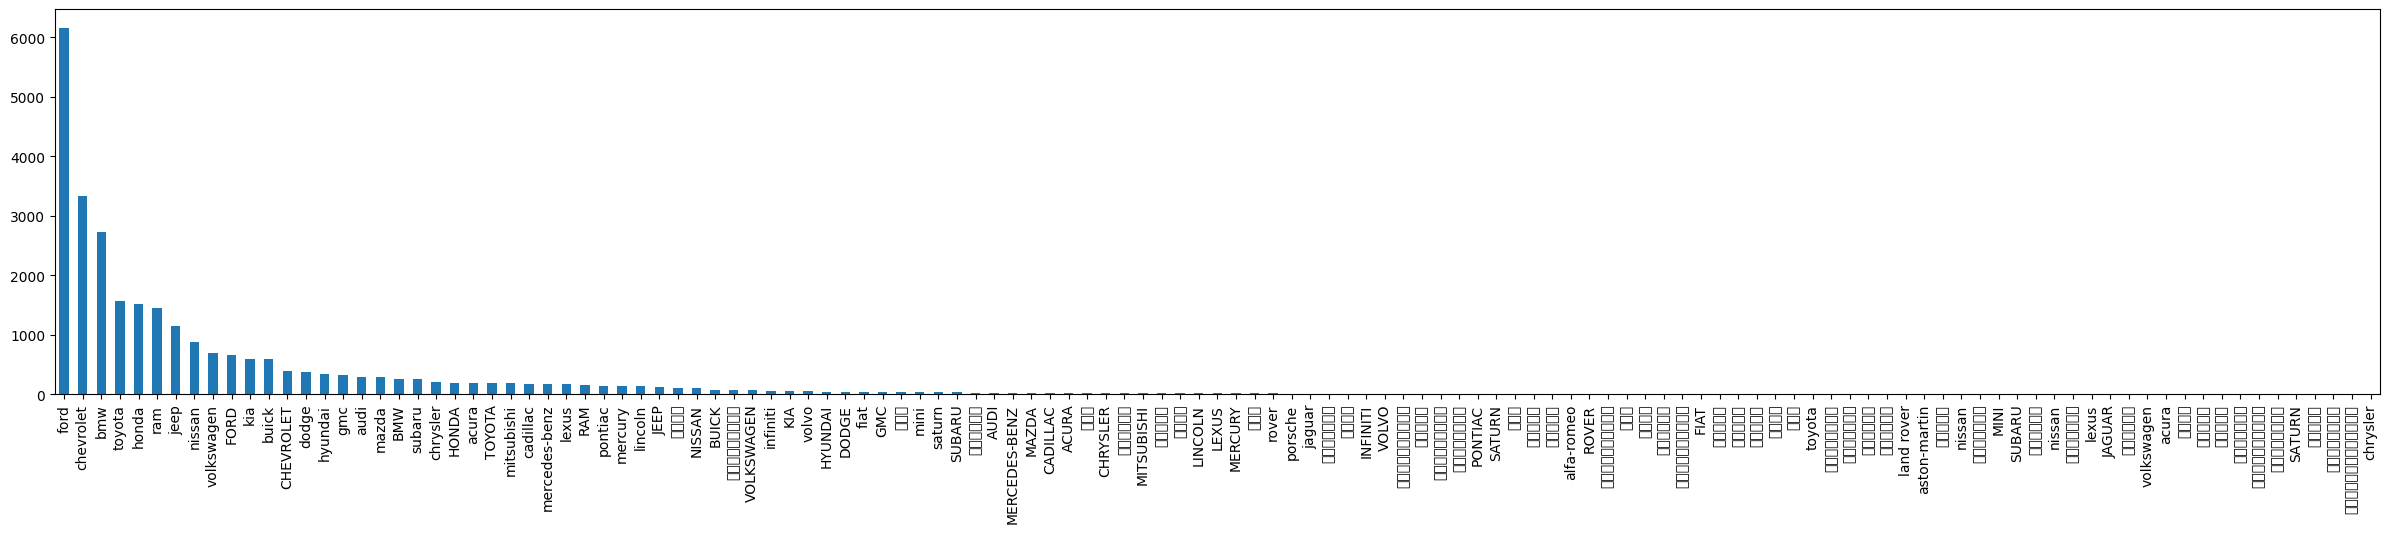

In [ ]:
counts_manufacturer.plot(kind='bar', figsize=(30,5))
# plt.tight_layout()
plt.show()

In [ ]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

        # sizeの表記揺れを修正
        X["size"] = X["size"].str.replace("ー", "-").astype(str)
        X["size"] = X["size"].str.replace("−", "-").astype(str)

        # manufacturerの表記揺れを修正
        X["manufacturer"] = X["manufacturer"].apply(
            lambda x: unicodedata.normalize("NFKC", x).lower()
        )

        # yearが3000年以降のものはおかしいので2000年に置換
        err_idx = X.query("year >= 3000").index
        X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

        # スケーリング
        # sc = StandardScaler()
        # sc.fit(X[['year', 'odometer', 'odemeter_per_year']])
        # X[['year', 'odometer', 'odemeter_per_year']] = sc.transform(X[['year', 'odometer', 'odemeter_per_year']])

        return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

# class RankTransformer(TransformerMixin, BaseEstimator):
#     """keyの中でvalueが何番目のものか"""

#     def __init__(self, key: str, value: str):
#         self.key = key
#         self.value = value

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X_new = X.copy()
#         X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense")
#         return X_new[self.get_feature_names_out()]

#     def get_feature_names_out(self, input_features=None):
#         return [self.key]


# class CountTransformer(TransformerMixin, BaseEstimator):
#     """CountEncoder"""

#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
#         self.ce.fit(X)
#         return self

#     def transform(self, X):
#         return self.ce.transform(X)

#     def get_feature_names_out(self, input_features=None):
#         return input_features


# class AggTransformer(TransformerMixin, BaseEstimator):
#     """集約特徴量"""

#     def __init__(self, key, numeric_cols, agg_func: dict):
#         self.key = key
#         self.numeric_cols = numeric_cols
#         self.agg_func = agg_func

#     def fit(self, X, y=None):
#         X = X.copy()
#         X[self.key] = X[self.key].astype("category")
#         self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
#         self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

#         return self

#     def transform(self, X):
#         X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
#         return X_new[self.get_feature_names_out()]

#     def get_feature_names_out(self, input_features=None):
#         return self.agg_df.columns.tolist()

In [ ]:
train_df.sample(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
24057,24057,mcallen / edinburg,2017,ｋｉａ,excellent,4 cylinders,gas,143681,clean,automatic,fwd,full-size,sedan,blue,tx,7956
11784,11784,sarasota-bradenton,1993,chevrolet,like new,8 cylinders,gas,154838,clean,automatic,4wd,full-size,pickup,green,fl,10931
23651,23651,south florida,2013,bmw,excellent,6 cylinders,gas,76785,clean,automatic,fwd,mid-size,sedan,black,NaN,3140
8039,8039,tampa bay area,2012,honda,good,4 cylinders,gas,250120,rebuilt,automatic,fwd,compact,hatchback,silver,fl,3540
19161,19161,denver,2015,honda,excellent,4 cylinders,gas,94686,clean,automatic,fwd,compact,SUV,blue,co,13101


In [ ]:
numeric_cols = ["year", "odometer", "odometer_per_year"]
categorical_cols = [
    #  'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                # 'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)

ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)

train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)

[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.1s


In [ ]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
1209,2018.0,46843.0,9368.599609,4.0,honda,like new,gas,clean,automatic,fwd,...,8898.821120,16565.674416,12282.452422,13371.433337,14025.651486,9892.702569,12158.134593,9999.857665,12156.773321,13559.877561
3364,2006.0,50785.0,2987.353027,4.0,chevrolet,good,gas,clean,manual,4wd,...,14834.987536,10971.909137,12225.230115,13247.724494,12061.623432,18671.671152,12115.821933,13790.471227,16845.835434,12994.304130
18114,2017.0,107187.0,17864.500000,4.0,ford,like new,gas,clean,automatic,fwd,...,14715.468636,16508.733506,12225.230115,13247.724494,13930.228325,9767.198243,8823.639157,9909.946582,8606.675932,13522.954424
11410,1989.0,157021.0,4618.264648,8.0,ford,good,gas,clean,automatic,fwd,...,14722.428347,11004.038807,12214.504336,13225.978879,13910.841120,9818.321203,15310.042973,20097.961340,13426.587474,13745.764216
6795,2011.0,110086.0,9173.833008,4.0,honda,excellent,gas,clean,manual,fwd,...,9009.020424,14585.322864,12214.504336,13225.978879,11895.073699,9818.321203,12096.899125,9956.111283,13426.587474,12330.679089


In [ ]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
#     if params is None:
#         params = {}

#     models = []
#     n_records = len(X)
#     oof_pred = np.zeros((n_records,), dtype=np.float32)

#     for i, (idx_train, idx_valid) in enumerate(cv):
#         x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#         x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#         model = cb.CatBoostRegressor(**params)
#         model.fit(
#             x_train,
#             y_train,
#             cat_features=categorical_cols,
#             eval_set=[(x_valid, y_valid)],
#             use_best_model=True,
#             early_stopping_rounds=100,
#             verbose=verbose,
#         )
#         pred_i = model.predict(x_valid)
#         oof_pred[idx_valid] = pred_i
#         models.append(model)
#         score = mean_absolute_percentage_error(y_valid, pred_i)
#         print(f" - fold{i + 1} - {score:.4f}")

#     score = mean_absolute_percentage_error(y, oof_pred)

#     print("=" * 50)
#     print(f"FINISH: Whole Score: {score:.4f}")
#     return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [ ]:
# train_df.info()

# float_cols = [
#     'ori__year',
#     'ori__odometer',
#     'ori__odometer_per_year',
# ]

# # スケーリング
# sc = StandardScaler()
# sc.fit(train_feat_df[float_cols])
# train_feat_df[float_cols] = sc.transform(train_feat_df[float_cols])

In [ ]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
6182,2001.0,62453.0,2838.772705,6.0,chevrolet,like new,gas,clean,manual,rwd,...,15159.697150,16565.674416,12282.452422,13371.433337,12068.654852,15815.212934,15504.861210,11756.232289,8680.599007,13559.877561
5772,2012.0,341560.0,31050.908203,6.0,toyota,fair,gas,clean,automatic,fwd,...,9180.128747,7233.156114,12282.452422,13371.433337,14025.651486,9892.702569,15504.861210,13837.067700,13551.867875,12211.370632
5188,2015.0,60201.0,7525.125000,4.0,buick,like new,gas,clean,automatic,fwd,...,10824.120518,16546.594761,12240.361505,13276.786034,13943.426349,9767.130897,15390.287351,9860.993469,13518.030498,13457.555387
27093,2013.0,71364.0,7136.399902,4.0,nissan,excellent,gas,clean,automatic,4wd,...,9929.229506,14680.774136,12240.361505,13276.786034,13943.426349,18695.824309,12229.251520,13891.894459,16875.820573,13457.555387
18131,1993.0,80229.0,2674.300049,8.0,chevrolet,good,diesel,clean,manual,4wd,...,15021.203070,11003.298800,25129.185788,13276.786034,12117.939502,18695.824309,15390.287351,13891.894459,14828.422588,13267.984400


In [ ]:
n_fold = 5
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "num_leaves": 32,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission.csv", index=False, header=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7dd0e9f67d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 200, in _log_callback
    _log_native(str(msg.decode('utf-8')))
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 178, in wrapper
    return func(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 195, in _log_native
    getattr(_LOGGER, _INFO_METHOD_NAME)(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 128, in info
    print(msg)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 402, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 203, in schedule
    self._event_pipe.send(b'')
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 618, in send
    return 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

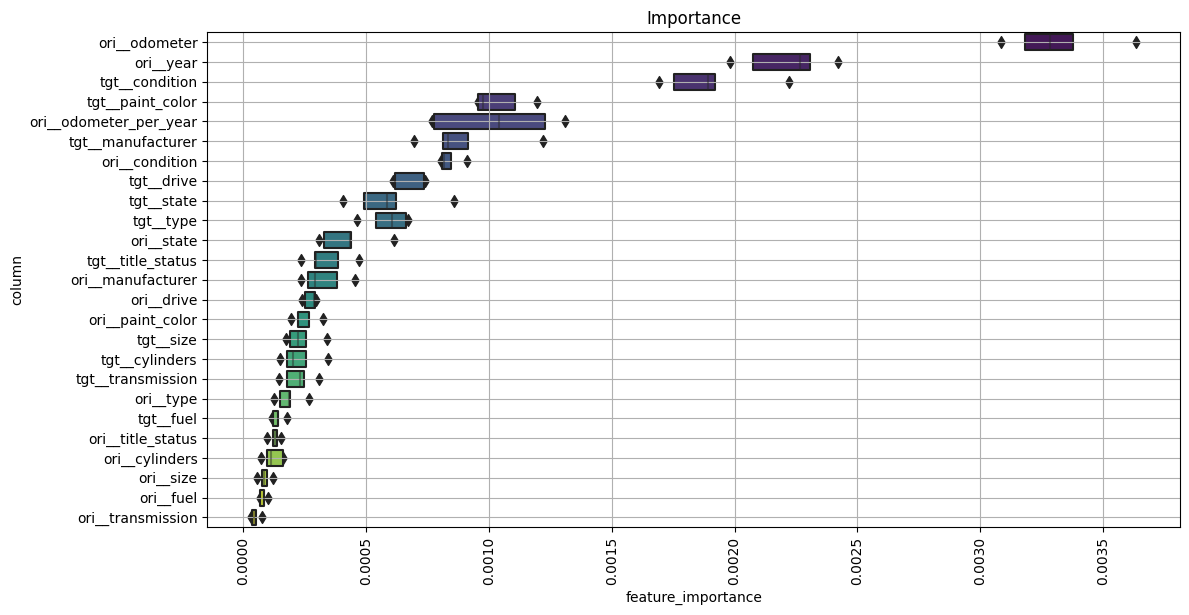

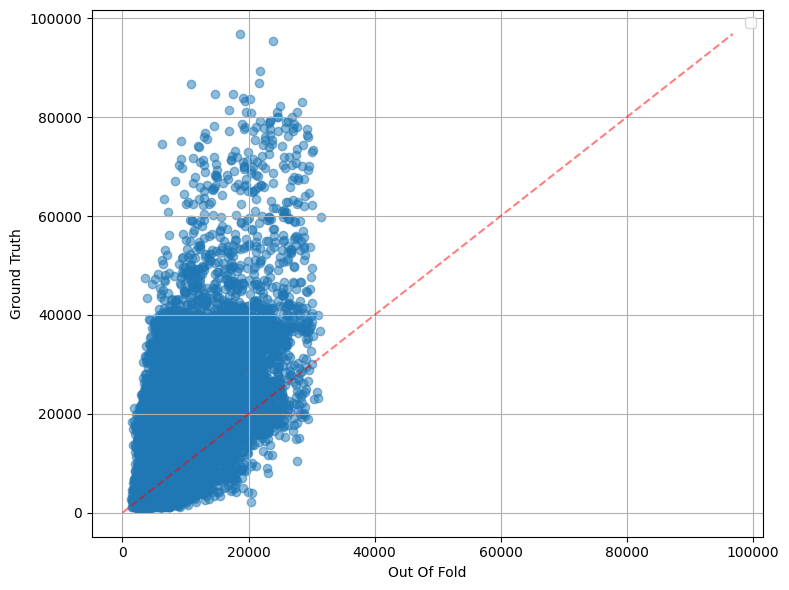

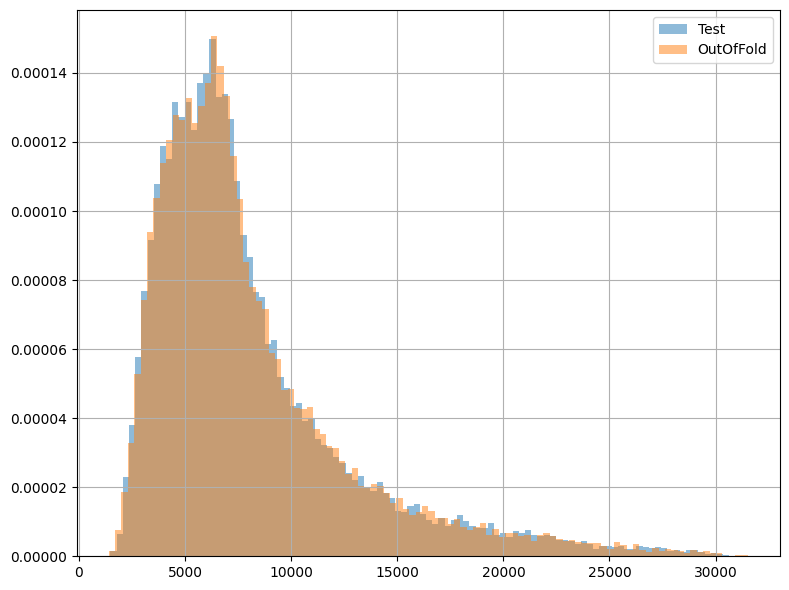

In [ ]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)